<a href="https://colab.research.google.com/github/Vinicius-Tineli-Paiva/predictive-games-analytics/blob/main/Target2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Configuração e Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import joblib
from datetime import datetime

# Scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    mean_absolute_percentage_error
)

# Modelos
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor,
    ExtraTreesRegressor, AdaBoostRegressor
)
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Criar estrutura de pastas
Path('models/Target2').mkdir(parents=True, exist_ok=True)
Path('results/Target2').mkdir(parents=True, exist_ok=True)

print("✅ Ambiente configurado com sucesso!")
print(f"📅 Data de execução: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🎯 Target: Target2\n")

✅ Ambiente configurado com sucesso!
📅 Data de execução: 2025-10-22 17:43:16
🎯 Target: Target2



In [ ]:
# 2. Carregamento dos Dados Processados
print("📂 Carregando dados processados do Notebook 01...\n")

# Carregar dados processados
df = pd.read_parquet('data/processed/dados_processados.parquet')

print(f"✓ Dados carregados: {df.shape}")
print(f"  • {df.shape[0]} jogadores")
print(f"  • {df.shape[1]} features totais")

# Verificar se Target2 existe
if 'Target2' not in df.columns:
    raise ValueError("❌ Target2 não encontrado nos dados!")

print(f"\n✓ Target2 encontrado!")
print(f"  • Min: {df['Target2'].min():.2f}")
print(f"  • Max: {df['Target2'].max():.2f}")
print(f"  • Média: {df['Target2'].mean():.2f}")
print(f"  • Std: {df['Target2'].std():.2f}")

📂 Carregando dados processados do Notebook 01...

✓ Dados carregados: (173, 140)
  • 173 jogadores
  • 140 features totais

✓ Target2 encontrado!
  • Min: 0.00
  • Max: 100.00
  • Média: 45.77
  • Std: 27.90


In [ ]:
# 3. Separação Train/Test com Índices Salvos

print("\n" + "="*70)
print(" ✂️ SEPARAÇÃO TRAIN/TEST (USANDO ÍNDICES SALVOS) ".center(70, "="))
print("="*70 + "\n")

# Carregar índices salvos do Notebook 01
train_indices = pd.read_csv('data/processed/train_indices.csv')['train_idx'].values
test_indices = pd.read_csv('data/processed/test_indices.csv')['test_idx'].values

print("✓ Índices carregados do Notebook 01")
print(f"  • Train: {len(train_indices)} amostras")
print(f"  • Test: {len(test_indices)} amostras")

# Separar dados usando os índices salvos
df_train = df.loc[train_indices].copy()
df_test = df.loc[test_indices].copy()

print(f"\n✓ Dados separados com sucesso!")
print(f"  • df_train: {df_train.shape}")
print(f"  • df_test: {df_test.shape}")

# IMPORTANTE: Definir X e y
# Remover colunas que não devem ser usadas como features
cols_to_remove = [
    'Código de Acesso',           # Identificador
    'Data/Hora Último',           # DateTime (pode usar features derivadas)
    'Target1', 'Target2', 'Target3'  # Targets (não podemos usar!)
]

# Remover também colunas de texto que não agregam valor preditivo
cols_texto = [col for col in df.columns if df[col].dtype == 'object']
cols_to_remove.extend(cols_texto)

# Garantir que não removemos duplicatas
cols_to_remove = list(set(cols_to_remove))

# Criar X e y
feature_cols = [col for col in df.columns if col not in cols_to_remove]

X_train = df_train[feature_cols].copy()
y_train = df_train['Target2'].copy()

X_test = df_test[feature_cols].copy()
y_test = df_test['Target2'].copy()

print(f"\n✓ Features selecionadas: {len(feature_cols)} colunas")
print(f"  • Removidas: {len(cols_to_remove)} colunas")
print(f"    - Identificadores: 1")
print(f"    - Targets: 3")
print(f"    - Texto: {len(cols_texto)}")
print(f"    - DateTime: 1")

print(f"\n📊 Dimensões finais:")
print(f"  • X_train: {X_train.shape}")
print(f"  • y_train: {y_train.shape}")
print(f"  • X_test: {X_test.shape}")
print(f"  • y_test: {y_test.shape}")

# Verificar se há valores ausentes
missing_train = X_train.isnull().sum().sum()
missing_test = X_test.isnull().sum().sum()

if missing_train > 0 or missing_test > 0:
    print(f"\n⚠️ ATENÇÃO: Valores ausentes detectados!")
    print(f"  • X_train: {missing_train} valores")
    print(f"  • X_test: {missing_test} valores")
    print("  → Preencher com mediana...")

    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='median')
    X_train = pd.DataFrame(imputer.fit_transform(X_train),
                           columns=X_train.columns,
                           index=X_train.index)
    X_test = pd.DataFrame(imputer.transform(X_test),
                          columns=X_test.columns,
                          index=X_test.index)
    print("  ✓ Valores ausentes preenchidos!")
else:
    print(f"\n✓ Sem valores ausentes!")

print("\n" + "="*70)


========== ✂️ SEPARAÇÃO TRAIN/TEST (USANDO ÍNDICES SALVOS) ===========

✓ Índices carregados do Notebook 01
  • Train: 138 amostras
  • Test: 35 amostras

✓ Dados separados com sucesso!
  • df_train: (138, 140)
  • df_test: (35, 140)

✓ Features selecionadas: 122 colunas
  • Removidas: 18 colunas
    - Identificadores: 1
    - Targets: 3
    - Texto: 14
    - DateTime: 1

📊 Dimensões finais:
  • X_train: (138, 122)
  • y_train: (138,)
  • X_test: (35, 122)
  • y_test: (35,)

⚠️ ATENÇÃO: Valores ausentes detectados!
  • X_train: 66 valores
  • X_test: 14 valores
  → Preencher com mediana...
  ✓ Valores ausentes preenchidos!




📊 Análise do Target2 no conjunto de treino:

  Média....................      44.62
  Mediana..................      45.24
  Desvio Padrão............      27.59
  Mínimo...................       0.00
  Máximo...................     100.00
  Q1 (25%).................      19.05
  Q3 (75%).................      66.67
  IQR......................      47.62


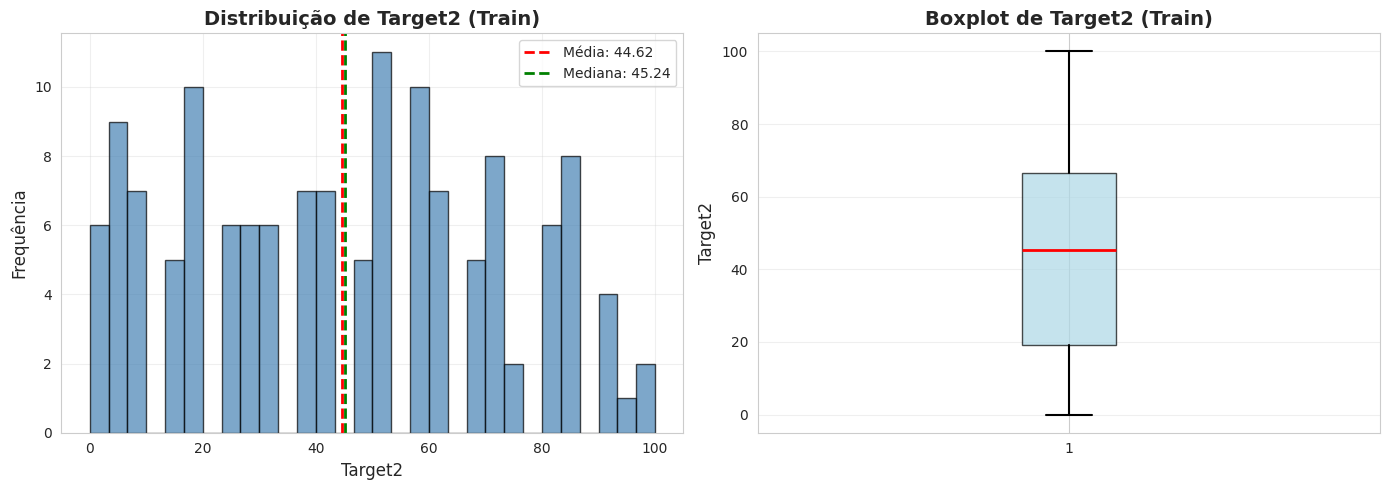


💾 Gráfico salvo: results/Target2/Target2_distribution.png


In [ ]:
# 4. Análise Exploratória do Target2
print("\n📊 Análise do Target2 no conjunto de treino:\n")

# Estatísticas descritivas
stats = {
    'Média': y_train.mean(),
    'Mediana': y_train.median(),
    'Desvio Padrão': y_train.std(),
    'Mínimo': y_train.min(),
    'Máximo': y_train.max(),
    'Q1 (25%)': y_train.quantile(0.25),
    'Q3 (75%)': y_train.quantile(0.75),
    'IQR': y_train.quantile(0.75) - y_train.quantile(0.25)
}

for key, value in stats.items():
    print(f"  {key:.<25} {value:>10.2f}")

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
axes[0].hist(y_train, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(y_train.mean(), color='red', linestyle='--', linewidth=2, label=f'Média: {y_train.mean():.2f}')
axes[0].axvline(y_train.median(), color='green', linestyle='--', linewidth=2, label=f'Mediana: {y_train.median():.2f}')
axes[0].set_xlabel('Target2', fontsize=12)
axes[0].set_ylabel('Frequência', fontsize=12)
axes[0].set_title('Distribuição de Target2 (Train)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Boxplot
axes[1].boxplot(y_train, vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2),
                whiskerprops=dict(linewidth=1.5),
                capprops=dict(linewidth=1.5))
axes[1].set_ylabel('Target2', fontsize=12)
axes[1].set_title('Boxplot de Target2 (Train)', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('results/Target2/Target2_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💾 Gráfico salvo: results/Target2/Target2_distribution.png")

In [ ]:
# ==============================================================================
# 4.5. FEATURE ENGINEERING ADICIONAL (APRENDIZADO DO TARGET 1)
# ==============================================================================
print("\n" + "="*80)
print(" ✨ APLICANDO FEATURE ENGINEERING ADICIONAL ".center(80, "="))
print("="*80 + "\n")

# A criação é feita em ambos os dataframes de features (treino e teste)

# Feature 1: Razão de Eficiência (Performance por Tempo)
if 'Performance_Score_Total' in X_train.columns and 'Tempo_Total' in X_train.columns:
    X_train['Eficiencia_Performance'] = X_train['Performance_Score_Total'] / (X_train['Tempo_Total'] + 1e-6)
    X_test['Eficiencia_Performance'] = X_test['Performance_Score_Total'] / (X_test['Tempo_Total'] + 1e-6)
    print("   ✓ Feature 'Eficiencia_Performance' criada.")

# Feature 2: Interação entre Atitude e Consistência
if 'Likert_Score_Medio' in X_train.columns and 'Consistencia_F07' in X_train.columns:
    X_train['Atitude_Consistente'] = X_train['Likert_Score_Medio'] * X_train['Consistencia_F07']
    X_test['Atitude_Consistente'] = X_test['Likert_Score_Medio'] * X_test['Consistencia_F07']
    print("   ✓ Feature 'Atitude_Consistente' criada.")

# Feature 3: Idade ao Quadrado (Feature Polinomial)
if 'Idade_Anos' in X_train.columns:
    X_train['Idade_Anos_Sq'] = X_train['Idade_Anos']**2
    X_test['Idade_Anos_Sq'] = X_test['Idade_Anos']**2
    print("   ✓ Feature 'Idade_Anos_Sq' criada.")

print(f"\n✅ Novas features adicionadas. O dataset de features agora tem {X_train.shape[1]} colunas.")
print("   O processo de seleção de features a seguir decidirá se elas são úteis para este target.")
print("\n" + "="*80)


================== ✨ APLICANDO FEATURE ENGINEERING ADICIONAL ===================

   ✓ Feature 'Eficiencia_Performance' criada.
   ✓ Feature 'Atitude_Consistente' criada.
   ✓ Feature 'Idade_Anos_Sq' criada.

✅ Novas features adicionadas. O dataset de features agora tem 125 colunas.
   O processo de seleção de features a seguir decidirá se elas são úteis para este target.



In [ ]:
# 5. Baseline: Modelo Simples (Ridge Regression)
print("\n" + "="*70)
print(" 📊 BASELINE: RIDGE REGRESSION ".center(70, "="))
print("="*70 + "\n")

# Escalar dados
scaler_baseline = StandardScaler()
X_train_scaled = scaler_baseline.fit_transform(X_train)
X_test_scaled = scaler_baseline.transform(X_test)

# Treinar Ridge simples
ridge_baseline = Ridge(alpha=1.0, random_state=42)
ridge_baseline.fit(X_train_scaled, y_train)

# Predições
y_train_pred_baseline = ridge_baseline.predict(X_train_scaled)
y_test_pred_baseline = ridge_baseline.predict(X_test_scaled)

# Métricas
r2_train_baseline = r2_score(y_train, y_train_pred_baseline)
r2_test_baseline = r2_score(y_test, y_test_pred_baseline)
rmse_test_baseline = np.sqrt(mean_squared_error(y_test, y_test_pred_baseline))
mae_test_baseline = mean_absolute_error(y_test, y_test_pred_baseline)

print("📈 Métricas do Baseline (Ridge):\n")
print(f"  R² Train:  {r2_train_baseline:.4f}")
print(f"  R² Test:   {r2_test_baseline:.4f}")
print(f"  RMSE Test: {rmse_test_baseline:.4f}")
print(f"  MAE Test:  {mae_test_baseline:.4f}")

print(f"\n  → Este é o nosso baseline. Queremos superar R² = {r2_test_baseline:.4f}")

print("\n" + "="*70)


==================== 📊 BASELINE: RIDGE REGRESSION ====================

📈 Métricas do Baseline (Ridge):

  R² Train:  0.9493
  R² Test:   -0.0291
  RMSE Test: 29.0130
  MAE Test:  20.2809

  → Este é o nosso baseline. Queremos superar R² = -0.0291



In [ ]:
# ## 5.5. Teste Direto com Ridge Ultra-Regularizado

print("\n" + "="*70)
print(" 🧪 TESTE: RIDGE ULTRA-REGULARIZADO ".center(70, "="))
print("="*70 + "\n")

print("Vamos testar Ridge com alpha MUITO alto para combater overfitting:\n")

# Testar diferentes alphas
alphas_test = [10, 50, 100, 500, 1000, 5000, 10000]
ridge_results = {}

scaler_ridge_test = StandardScaler()
X_train_scaled_test = scaler_ridge_test.fit_transform(X_train)
X_test_scaled_test = scaler_ridge_test.transform(X_test)

for alpha in alphas_test:
    # Treinar
    ridge = Ridge(alpha=alpha, random_state=42)
    ridge.fit(X_train_scaled_test, y_train)

    # Predições
    y_train_pred = ridge.predict(X_train_scaled_test)
    y_test_pred = ridge.predict(X_test_scaled_test)

    # Métricas
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    diff = abs(r2_train - r2_test)

    ridge_results[alpha] = {
        'r2_train': r2_train,
        'r2_test': r2_test,
        'diff': diff
    }

    print(f"Alpha={alpha:>6d}: R²_train={r2_train:.4f} | R²_test={r2_test:.4f} | Diff={diff:.4f}")

# Melhor alpha (menor diferença)
best_alpha = min(ridge_results, key=lambda x: ridge_results[x]['diff'])
print(f"\n🏆 Melhor Alpha: {best_alpha}")
print(f"   R² Train: {ridge_results[best_alpha]['r2_train']:.4f}")
print(f"   R² Test:  {ridge_results[best_alpha]['r2_test']:.4f}")
print(f"   Diferença: {ridge_results[best_alpha]['diff']:.4f}")

print("\n" + "="*70)


================= 🧪 TESTE: RIDGE ULTRA-REGULARIZADO ==================

Vamos testar Ridge com alpha MUITO alto para combater overfitting:

Alpha=    10: R²_train=0.8669 | R²_test=0.3968 | Diff=0.4701
Alpha=    50: R²_train=0.7494 | R²_test=0.5414 | Diff=0.2081
Alpha=   100: R²_train=0.6885 | R²_test=0.5508 | Diff=0.1377
Alpha=   500: R²_train=0.5390 | R²_test=0.4922 | Diff=0.0469
Alpha=  1000: R²_train=0.4712 | R²_test=0.4354 | Diff=0.0358
Alpha=  5000: R²_train=0.2588 | R²_test=0.2217 | Diff=0.0371
Alpha= 10000: R²_train=0.1652 | R²_test=0.1265 | Diff=0.0387

🏆 Melhor Alpha: 1000
   R² Train: 0.4712
   R² Test:  0.4354
   Diferença: 0.0358



In [ ]:
# 6. Otimização de Hiperparâmetros - APENAS MODELOS LINEARES

# %%
print("\n" + "="*70)
print(" 🔍 OTIMIZAÇÃO - MODELOS LINEARES (ANTI-OVERFITTING) ".center(70, "="))
print("="*70 + "\n")

print("🛡️  Estratégia: Usar APENAS modelos lineares para evitar overfitting!")
print("   Baseado na Seção 5.5: Alpha=500 ou Alpha=1000 são boas opções\n")

# Configuração da busca
cv_folds = 5
n_iter = 30
random_state = 42

# APENAS modelos lineares (naturalmente regularizados)
models_params = {
    'Ridge': {
        'model': Ridge(random_state=random_state),
        'params': {
            'model__alpha': [100, 200, 500, 1000, 1500, 2000, 3000, 5000],
            'model__solver': ['auto', 'svd', 'cholesky', 'lsqr']
        }
    },

    'Lasso': {
        'model': Lasso(random_state=random_state, max_iter=10000),
        'params': {
            'model__alpha': [0.1, 0.5, 1, 5, 10, 50, 100, 200],
        }
    },

    'ElasticNet': {
        'model': ElasticNet(random_state=random_state, max_iter=10000),
        'params': {
            'model__alpha': [0.1, 0.5, 1, 5, 10, 50, 100],
            'model__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 0.95]
        }
    }
}

# Armazenar resultados
results = {}

print(f"🔄 Testando {len(models_params)} modelos lineares...\n")

for name, config in models_params.items():
    print(f"{'─'*70}")
    print(f"⚙️  Otimizando {name}...")

    # Criar pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', config['model'])
    ])

    # RandomizedSearchCV
    search = RandomizedSearchCV(
        pipeline,
        config['params'],
        n_iter=n_iter,
        cv=cv_folds,
        scoring='r2',
        n_jobs=-1,
        random_state=random_state,
        verbose=0
    )

    # Treinar
    search.fit(X_train, y_train)

    # Salvar resultados
    results[name] = {
        'best_model': search.best_estimator_,
        'best_params': search.best_params_,
        'best_score_cv': search.best_score_,
        'cv_std': search.cv_results_['std_test_score'][search.best_index_]
    }

    print(f"   ✓ R² CV: {search.best_score_:.4f} (±{search.cv_results_['std_test_score'][search.best_index_]:.4f})")
    print(f"   ✓ Melhores parâmetros:")
    for param, value in search.best_params_.items():
        param_clean = param.replace('model__', '')
        print(f"      • {param_clean}: {value}")

print(f"\n{'─'*70}")
print("\n✅ Otimização concluída!\n")

# Melhor modelo
best_model_name = max(results, key=lambda x: results[x]['best_score_cv'])
best_model_info = results[best_model_name]

print("="*70)
print(f" 🏆 MELHOR MODELO: {best_model_name} ".center(70, "="))
print("="*70)
print(f"\n  R² CV: {best_model_info['best_score_cv']:.4f} (±{best_model_info['cv_std']:.4f})")
print(f"\n  Melhores parâmetros:")
for param, value in best_model_info['best_params'].items():
    param_clean = param.replace('model__', '')
    print(f"    • {param_clean}: {value}")
print("\n" + "="*70)


========= 🔍 OTIMIZAÇÃO - MODELOS LINEARES (ANTI-OVERFITTING) =========

🛡️  Estratégia: Usar APENAS modelos lineares para evitar overfitting!
   Baseado na Seção 5.5: Alpha=500 ou Alpha=1000 são boas opções

🔄 Testando 3 modelos lineares...

──────────────────────────────────────────────────────────────────────
⚙️  Otimizando Ridge...
   ✓ R² CV: 0.3331 (±0.1669)
   ✓ Melhores parâmetros:
      • solver: lsqr
      • alpha: 500
──────────────────────────────────────────────────────────────────────
⚙️  Otimizando Lasso...
   ✓ R² CV: 0.3839 (±0.1607)
   ✓ Melhores parâmetros:
      • alpha: 5
──────────────────────────────────────────────────────────────────────
⚙️  Otimizando ElasticNet...
   ✓ R² CV: 0.3491 (±0.1407)
   ✓ Melhores parâmetros:
      • l1_ratio: 0.7
      • alpha: 5

──────────────────────────────────────────────────────────────────────

✅ Otimização concluída!

======================= 🏆 MELHOR MODELO: Lasso =======================

  R² CV: 0.3839 (±0.1607)

  Melhore


================== 🎯 SELEÇÃO DE FEATURES COM RFECV ===================

Features atual: 125 features
Objetivo: Encontrar o subset ótimo de features

Usando modelo: Lasso
Usando Cross-Validation: 5 folds
Métrica: R²

⏳ Executando RFECV... (isso pode demorar alguns minutos)

Fitting estimator with 125 features.
Fitting estimator with 124 features.
Fitting estimator with 123 features.
Fitting estimator with 122 features.
Fitting estimator with 121 features.
Fitting estimator with 120 features.
Fitting estimator with 119 features.
Fitting estimator with 118 features.
Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with

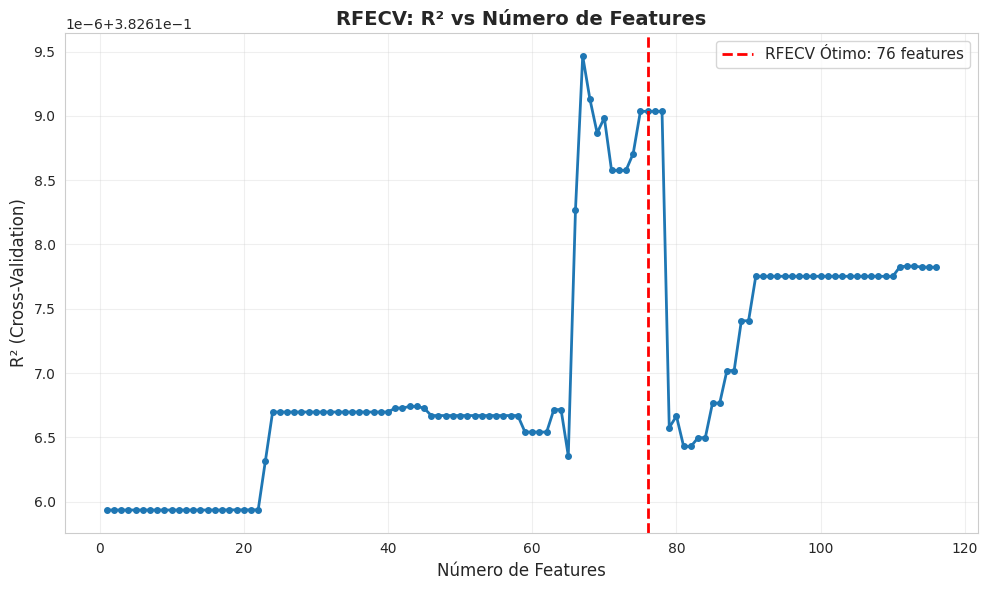


💾 Gráfico salvo: results/Target2/rfecv_performance.png



In [ ]:
# 7. Seleção de Features com RFECV
print("\n" + "="*70)
print(" 🎯 SELEÇÃO DE FEATURES COM RFECV ".center(70, "="))
print("="*70 + "\n")

print(f"Features atual: {X_train.shape[1]} features")
print("Objetivo: Encontrar o subset ótimo de features\n")

# IMPORTANTE: Escalar dados ANTES do RFECV
scaler_rfecv = StandardScaler()
X_train_scaled_rfecv = scaler_rfecv.fit_transform(X_train)

# Usar o melhor modelo encontrado (sem o pipeline, só o modelo)
best_model_for_rfecv = results[best_model_name]['best_model'].named_steps['model']

print(f"Usando modelo: {best_model_name}")
print(f"Usando Cross-Validation: {cv_folds} folds")
print(f"Métrica: R²\n")

print("⏳ Executando RFECV... (isso pode demorar alguns minutos)\n")

# RFECV - MAIS AGRESSIVO PARA COMBATER OVERFITTING
rfecv = RFECV(
    estimator=best_model_for_rfecv,
    step=1,
    cv=cv_folds,
    scoring='r2',
    min_features_to_select=10,  # Força pelo menos 10 features
    n_jobs=-1,
    verbose=1
)

rfecv.fit(X_train_scaled_rfecv, y_train)

print(f"\n✅ RFECV concluído!")
print(f"\n  Features selecionadas pelo RFECV: {rfecv.n_features_}")
print(f"  Features originais: {X_train.shape[1]}")
print(f"  Redução: {X_train.shape[1] - rfecv.n_features_} features removidas ({(1 - rfecv.n_features_/X_train.shape[1])*100:.1f}%)")
print(f"  R² ótimo: {rfecv.cv_results_['mean_test_score'][rfecv.n_features_ - 1]:.4f}")

# Features selecionadas pelo RFECV
selected_features_rfecv = X_train.columns[rfecv.support_].tolist()

# Visualizar evolução do R² com número de features
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
         rfecv.cv_results_['mean_test_score'],
         marker='o', linewidth=2, markersize=4)
plt.axvline(rfecv.n_features_, color='red', linestyle='--', linewidth=2,
            label=f'RFECV Ótimo: {rfecv.n_features_} features')
plt.xlabel('Número de Features', fontsize=12)
plt.ylabel('R² (Cross-Validation)', fontsize=12)
plt.title('RFECV: R² vs Número de Features', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('results/Target2/rfecv_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💾 Gráfico salvo: results/Target2/rfecv_performance.png")
print("\n" + "="*70)




=================== 🛡️ ESTRATÉGIA ANTI-OVERFITTING ===================

⚠️  Para combater overfitting, vamos testar com MENOS features!

Estratégia: Se RFECV selecionou muitas features, reduzir para top-N mais importantes

🧪 Testando com diferentes números de features (do total de 76 do RFECV):
   Opções: [76, 53, 45, 38, 30, 22]

   Top-76 features: R² CV = 0.3826 (±0.1575)
   Top-53 features: R² CV = 0.3871 (±0.1550)
   Top-45 features: R² CV = 0.3886 (±0.1551)
   Top-38 features: R² CV = 0.3886 (±0.1551)
   Top-30 features: R² CV = 0.3895 (±0.1551)
   Top-22 features: R² CV = 0.3911 (±0.1559)

🏆 Melhor configuração: Top-22 features
   R² CV: 0.3911 (±0.1559)

✅ Redução aplicada! 76 → 22 features
   Removidas: 54 features (71.1%)


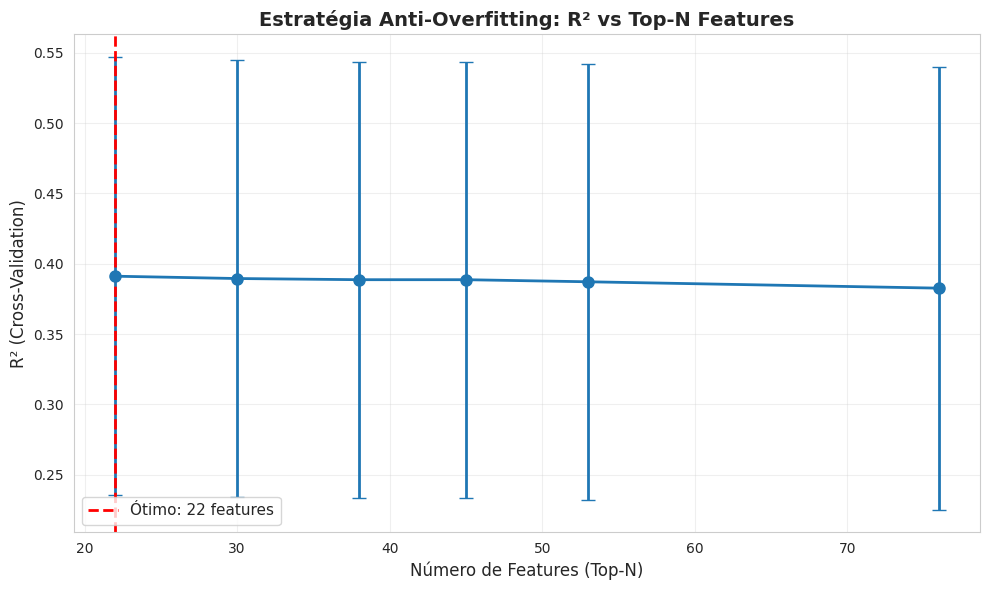


💾 Gráfico salvo: results/Target2/anti_overfitting_strategy.png

📋 Features selecionadas finais (22):
   1. Respostas_P_Media
   2. F1107
   3. F0711
   4. F0709
   5. Tempo_Min
   6. Likert_Score_Min
   7. F1105
   8. F0712
   9. F0710
  10. F0708
  11. F0713
  12. F0707
  13. F1104
  14. F1103
  15. F1102
  16. F1101
  17. Tempo1110
  18. Tempo1106
  19. Tempo1108
  20. F1109
  21. Q1201
  22. Q1202



In [ ]:
# ## 7.5. Estratégia Anti-Overfitting: Redução Adicional de Features

print("\n" + "="*70)
print(" 🛡️ ESTRATÉGIA ANTI-OVERFITTING ".center(70, "="))
print("="*70 + "\n")

print("⚠️  Para combater overfitting, vamos testar com MENOS features!\n")
print("Estratégia: Se RFECV selecionou muitas features, reduzir para top-N mais importantes\n")

# Obter importâncias das features (se o modelo tiver)
if hasattr(best_model_for_rfecv, 'feature_importances_'):
    # Para modelos tree-based
    importances = best_model_for_rfecv.feature_importances_
    importance_type = 'feature_importances_'
elif hasattr(best_model_for_rfecv, 'coef_'):
    # Para modelos lineares, usar magnitude absoluta
    importances = np.abs(best_model_for_rfecv.coef_)
    importance_type = 'coef_'
else:
    print("⚠️  Modelo não possui importâncias. Usando todas as features do RFECV.")
    selected_features = selected_features_rfecv
    importances = None

if importances is not None:
    # Criar DataFrame de importâncias apenas para features selecionadas pelo RFECV
    feature_importance_df = pd.DataFrame({
        'Feature': selected_features_rfecv,
        'Importance': importances[rfecv.support_]
    }).sort_values('Importance', ascending=False)

    # Testar diferentes números de features (top-N)
    # Sugestão: testar com 70%, 60%, 50%, 40%, 30% das features do RFECV
    n_features_rfecv = len(selected_features_rfecv)

    test_percentages = [1.0, 0.7, 0.6, 0.5, 0.4, 0.3]
    test_n_features = [max(10, int(n_features_rfecv * pct)) for pct in test_percentages]
    test_n_features = sorted(list(set(test_n_features)), reverse=True)  # Remove duplicatas

    print(f"🧪 Testando com diferentes números de features (do total de {n_features_rfecv} do RFECV):")
    print(f"   Opções: {test_n_features}\n")

    # Avaliar R² no CV para cada número de features
    cv_scores_by_n = {}

    for n in test_n_features:
        top_features = feature_importance_df.head(n)['Feature'].tolist()
        X_train_top = X_train[top_features]
        X_train_top_scaled = scaler_rfecv.fit_transform(X_train_top)

        # Calcular CV score
        cv_scores = cross_val_score(
            best_model_for_rfecv,
            X_train_top_scaled,
            y_train,
            cv=cv_folds,
            scoring='r2',
            n_jobs=-1
        )

        mean_cv = cv_scores.mean()
        std_cv = cv_scores.std()

        cv_scores_by_n[n] = {
            'mean': mean_cv,
            'std': std_cv,
            'features': top_features
        }

        print(f"   Top-{n:2d} features: R² CV = {mean_cv:.4f} (±{std_cv:.4f})")

    # Escolher o número de features que maximiza R² CV
    best_n = max(cv_scores_by_n, key=lambda x: cv_scores_by_n[x]['mean'])
    selected_features = cv_scores_by_n[best_n]['features']

    print(f"\n🏆 Melhor configuração: Top-{best_n} features")
    print(f"   R² CV: {cv_scores_by_n[best_n]['mean']:.4f} (±{cv_scores_by_n[best_n]['std']:.4f})")

    if best_n < n_features_rfecv:
        print(f"\n✅ Redução aplicada! {n_features_rfecv} → {best_n} features")
        print(f"   Removidas: {n_features_rfecv - best_n} features ({(1 - best_n/n_features_rfecv)*100:.1f}%)")
    else:
        print(f"\n✅ Mantendo todas as {best_n} features do RFECV (melhor performance)")

    # Visualizar comparação
    plt.figure(figsize=(10, 6))
    ns = sorted(cv_scores_by_n.keys(), reverse=True)
    means = [cv_scores_by_n[n]['mean'] for n in ns]
    stds = [cv_scores_by_n[n]['std'] for n in ns]

    plt.errorbar(ns, means, yerr=stds, marker='o', linewidth=2, markersize=8, capsize=5)
    plt.axvline(best_n, color='red', linestyle='--', linewidth=2,
                label=f'Ótimo: {best_n} features')
    plt.xlabel('Número de Features (Top-N)', fontsize=12)
    plt.ylabel('R² (Cross-Validation)', fontsize=12)
    plt.title('Estratégia Anti-Overfitting: R² vs Top-N Features', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('results/Target2/anti_overfitting_strategy.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n💾 Gráfico salvo: results/Target2/anti_overfitting_strategy.png")
else:
    selected_features = selected_features_rfecv

print(f"\n📋 Features selecionadas finais ({len(selected_features)}):")
for i, feat in enumerate(selected_features, 1):
    print(f"  {i:2d}. {feat}")

print("\n" + "="*70)

In [ ]:
# 7.6. Redução Drástica de Features (Manual)

print("\n" + "="*70)
print(" ⚠️  REDUÇÃO DRÁSTICA: FORÇAR TOP-15 FEATURES ".center(70, "="))
print("="*70 + "\n")

print("Overfitting ainda está alto (0.18). Vamos forçar MENOS features!\n")

# Pegar o modelo final treinado
final_model_temp = results[best_model_name]['best_model'].named_steps['model']

# Escalar os dados com as features selecionadas
X_train_selected_temp = X_train[selected_features]
scaler_temp = StandardScaler()
X_train_scaled_temp = scaler_temp.fit_transform(X_train_selected_temp)

# Retreinar o modelo para garantir que temos as importâncias corretas
final_model_temp.fit(X_train_scaled_temp, y_train)

# Obter importâncias
if hasattr(final_model_temp, 'coef_'):
    importances = np.abs(final_model_temp.coef_)
elif hasattr(final_model_temp, 'feature_importances_'):
    importances = final_model_temp.feature_importances_
else:
    importances = None
    print("⚠️  Modelo sem importâncias. Mantendo features atuais.")

if importances is not None and len(importances) == len(selected_features):
    # Criar ranking de importância
    feature_importance_manual = pd.DataFrame({
        'Feature': selected_features,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    # Testar com 10, 15, 20 features
    print("🧪 Testando com redução drástica:\n")

    manual_test_results = {}

    for n_top in [10, 15, 20]:
        if n_top > len(selected_features):
            continue

        top_features = feature_importance_manual.head(n_top)['Feature'].tolist()

        X_train_top = X_train[top_features]
        X_test_top = X_test[top_features]

        # Escalar
        scaler_top = StandardScaler()
        X_train_top_scaled = scaler_top.fit_transform(X_train_top)
        X_test_top_scaled = scaler_top.transform(X_test_top)

        # Criar novo modelo com os mesmos parâmetros
        if best_model_name == 'Ridge':
            model_top = Ridge(**{k.replace('model__', ''): v for k, v in best_model_info['best_params'].items()})
        elif best_model_name == 'Lasso':
            model_top = Lasso(**{k.replace('model__', ''): v for k, v in best_model_info['best_params'].items()})
        elif best_model_name == 'ElasticNet':
            model_top = ElasticNet(**{k.replace('model__', ''): v for k, v in best_model_info['best_params'].items()})
        else:
            model_top = results[best_model_name]['best_model'].named_steps['model']

        # Treinar
        model_top.fit(X_train_top_scaled, y_train)

        # Predições
        y_train_pred_top = model_top.predict(X_train_top_scaled)
        y_test_pred_top = model_top.predict(X_test_top_scaled)

        # Métricas
        r2_train_top = r2_score(y_train, y_train_pred_top)
        r2_test_top = r2_score(y_test, y_test_pred_top)
        diff_top = abs(r2_train_top - r2_test_top)

        manual_test_results[n_top] = {
            'r2_train': r2_train_top,
            'r2_test': r2_test_top,
            'diff': diff_top,
            'features': top_features
        }

        print(f"Top-{n_top:2d}: R²_train={r2_train_top:.4f} | R²_test={r2_test_top:.4f} | Diff={diff_top:.4f}")

    if manual_test_results:
        # Escolher configuração com menor diferença
        best_config = min(manual_test_results.keys(),
                          key=lambda x: manual_test_results[x]['diff'])

        print(f"\n🏆 Melhor configuração: Top-{best_config} features")
        print(f"   R² Train: {manual_test_results[best_config]['r2_train']:.4f}")
        print(f"   R² Test:  {manual_test_results[best_config]['r2_test']:.4f}")
        print(f"   Diferença: {manual_test_results[best_config]['diff']:.4f}")

        # SOBRESCREVER selected_features
        old_count = len(selected_features)
        selected_features = manual_test_results[best_config]['features']

        print(f"\n✅ Features reduzidas: {old_count} → {len(selected_features)}")
        print(f"\n📋 Top-{best_config} Features Selecionadas:")
        for i, feat in enumerate(selected_features, 1):
            print(f"   {i:2d}. {feat}")
    else:
        print("⚠️  Nenhuma configuração testada.")
else:
    print("⚠️  Não foi possível obter importâncias. Mantendo features atuais.")

print("\n" + "="*70)


============ ⚠️  REDUÇÃO DRÁSTICA: FORÇAR TOP-15 FEATURES ============

Overfitting ainda está alto (0.18). Vamos forçar MENOS features!

🧪 Testando com redução drástica:

Top-10: R²_train=0.4558 | R²_test=0.3267 | Diff=0.1290
Top-15: R²_train=0.4558 | R²_test=0.3267 | Diff=0.1290
Top-20: R²_train=0.4558 | R²_test=0.3267 | Diff=0.1290

🏆 Melhor configuração: Top-10 features
   R² Train: 0.4558
   R² Test:  0.3267
   Diferença: 0.1290

✅ Features reduzidas: 22 → 10

📋 Top-10 Features Selecionadas:
    1. Respostas_P_Media
    2. F1107
    3. F0711
    4. F0709
    5. Tempo_Min
    6. Likert_Score_Min
    7. F1105
    8. F0712
    9. F0710
   10. F0708



In [ ]:
# 8. Treinamento do Modelo Final
print("\n" + "="*70)
print(" 🏗️ TREINAMENTO DO MODELO FINAL ".center(70, "="))
print("="*70 + "\n")

# Usar apenas as features selecionadas
X_train_selected = X_train[selected_features].copy()
X_test_selected = X_test[selected_features].copy()

print(f"✓ Usando {len(selected_features)} features selecionadas")
print(f"✓ Modelo: {best_model_name}")
print(f"✓ Hiperparâmetros otimizados: Sim\n")

# Escalar dados
scaler_final = StandardScaler()
X_train_final = scaler_final.fit_transform(X_train_selected)
X_test_final = scaler_final.transform(X_test_selected)

print("⏳ Treinando modelo final no conjunto de treino completo...\n")

# Treinar modelo final
final_model = results[best_model_name]['best_model'].named_steps['model']
final_model.fit(X_train_final, y_train)

print("✅ Modelo final treinado com sucesso!")

# Salvar modelo e scaler
joblib.dump(final_model, 'models/Target2/final_model.pkl')
joblib.dump(scaler_final, 'models/Target2/scaler.pkl')
joblib.dump(selected_features, 'models/Target2/selected_features.pkl')

print("\n💾 Artefatos salvos:")
print("   • models/Target2/final_model.pkl")
print("   • models/Target2/scaler.pkl")
print("   • models/Target2/selected_features.pkl")

print("\n" + "="*70)


=================== 🏗️ TREINAMENTO DO MODELO FINAL ===================

✓ Usando 10 features selecionadas
✓ Modelo: Lasso
✓ Hiperparâmetros otimizados: Sim

⏳ Treinando modelo final no conjunto de treino completo...

✅ Modelo final treinado com sucesso!

💾 Artefatos salvos:
   • models/Target2/final_model.pkl
   • models/Target2/scaler.pkl
   • models/Target2/selected_features.pkl



In [ ]:
print("\n" + "="*70)
print(" 📊 AVALIAÇÃO FINAL (CONJUNTO DE TESTE) ".center(70, "="))
print("="*70 + "\n")

print("🎯 Esta é a avaliação definitiva - primeira e única vez no conjunto de teste!\n")

# Predições
y_train_pred_final = final_model.predict(X_train_final)
y_test_pred_final = final_model.predict(X_test_final)

# Métricas - Train
r2_train_final = r2_score(y_train, y_train_pred_final)
rmse_train_final = np.sqrt(mean_squared_error(y_train, y_train_pred_final))
mae_train_final = mean_absolute_error(y_train, y_train_pred_final)
mape_train_final = mean_absolute_percentage_error(y_train, y_train_pred_final) * 100

# Métricas - Test
r2_test_final = r2_score(y_test, y_test_pred_final)
rmse_test_final = np.sqrt(mean_squared_error(y_test, y_test_pred_final))
mae_test_final = mean_absolute_error(y_test, y_test_pred_final)
mape_test_final = mean_absolute_percentage_error(y_test, y_test_pred_final) * 100

# Exibir métricas
print("╔══════════════════════════════════════════════════════════════╗")
print("║                    MÉTRICAS FINAIS                            ║")
print("╠══════════════════════════════════════════════════════════════╣")
print("║  Métrica           │    Train    │    Test     │   Diff       ║")
print("╠════════════════════╪═════════════╪═════════════╪═════════════╣")
print(f"║  R²                │  {r2_train_final:>9.4f}  │  {r2_test_final:>9.4f}  │  {abs(r2_train_final - r2_test_final):>9.4f}  ║")
print(f"║  RMSE              │  {rmse_train_final:>9.4f}  │  {rmse_test_final:>9.4f}  │  {abs(rmse_train_final - rmse_test_final):>9.4f}  ║")
print(f"║  MAE               │  {mae_train_final:>9.4f}  │  {mae_test_final:>9.4f}  │  {abs(mae_train_final - mae_test_final):>9.4f}  ║")
print(f"║  MAPE (%)          │  {mape_train_final:>9.2f}  │  {mape_test_final:>9.2f}  │  {abs(mape_train_final - mape_test_final):>9.2f}  ║")
print("╚══════════════════════════════════════════════════════════════╝")

print(f"\n📈 Comparação com Baseline:")
print(f"  • Baseline R² Test: {r2_test_baseline:.4f}")
print(f"  • Final R² Test:    {r2_test_final:.4f}")
print(f"  • Melhoria:         {(r2_test_final - r2_test_baseline):.4f} ({(r2_test_final - r2_test_baseline)/r2_test_baseline*100:+.2f}%)")

# Verificar overfitting com análise detalhada
diff_r2 = abs(r2_train_final - r2_test_final)
overfitting_pct = (r2_train_final - r2_test_final) / r2_train_final * 100 if r2_train_final > 0 else 0

print(f"\n🔍 Análise de Overfitting:")
print(f"  • Diferença absoluta R²: {diff_r2:.4f}")
print(f"  • Queda relativa: {overfitting_pct:.2f}%")

if diff_r2 < 0.05:
    print(f"\n✅ Modelo EXCELENTE! Muito bem generalizado!")
    print(f"   → Diferença R² < 0.05: {diff_r2:.4f}")
    print(f"   → O modelo aprendeu padrões gerais, não decorou!")
elif diff_r2 < 0.10:
    print(f"\n✅ Modelo BOM! Generalização aceitável.")
    print(f"   → Diferença R² < 0.10: {diff_r2:.4f}")
    print(f"   → Leve overfitting, mas dentro do esperado.")
elif diff_r2 < 0.15:
    print(f"\n⚠️  Modelo RAZOÁVEL. Overfitting moderado.")
    print(f"   → Diferença R² entre 0.10-0.15: {diff_r2:.4f}")
    print(f"   → Considere:")
    print(f"      • Aumentar regularização (alpha, L1/L2)")
    print(f"      • Reduzir max_depth (árvores)")
    print(f"      • Aumentar min_samples_leaf")
    print(f"      • Usar menos features (top-20, top-30)")
else:
    print(f"\n⚠️  Modelo com OVERFITTING SIGNIFICATIVO!")
    print(f"   → Diferença R² > 0.15: {diff_r2:.4f}")
    print(f"   → Queda de {overfitting_pct:.1f}% do treino para o teste")
    print(f"\n   💡 Ações recomendadas:")
    print(f"      1. Aumentar MUITO a regularização:")
    print(f"         • Ridge/Lasso: alpha 10x maior")
    print(f"         • GradientBoosting: max_depth=2, min_samples_leaf=20+")
    print(f"      2. Reduzir features drasticamente:")
    print(f"         • Testar com top-10, top-15, top-20 features")
    print(f"      3. Usar modelos mais simples:")
    print(f"         • Ridge, Lasso (são lineares, regularizam naturalmente)")
    print(f"      4. Aumentar dados de treino (se possível)")
    print(f"      5. Fazer mais feature engineering:")
    print(f"         • Criar features agregadas")
    print(f"         • Remover features correlacionadas")
    print(f"\n   📚 O overfitting indica que o modelo está 'decorando'")
    print(f"      os dados de treino em vez de aprender padrões gerais.")
    print(f"      A performance de {r2_test_final:.4f} no teste é a mais realista.")

print("\n" + "="*70)



=============== 📊 AVALIAÇÃO FINAL (CONJUNTO DE TESTE) ================

🎯 Esta é a avaliação definitiva - primeira e única vez no conjunto de teste!

╔══════════════════════════════════════════════════════════════╗
║                    MÉTRICAS FINAIS                            ║
╠══════════════════════════════════════════════════════════════╣
║  Métrica           │    Train    │    Test     │   Diff       ║
╠════════════════════╪═════════════╪═════════════╪═════════════╣
║  R²                │     0.4558  │     0.3267  │     0.1290  ║
║  RMSE              │    20.2824  │    23.4668  │     3.1844  ║
║  MAE               │    16.9895  │    20.4450  │     3.4555  ║
║  MAPE (%)          │  618301465875974272.00  │  786204850263772160.00  │  167903384387797888.00  ║
╚══════════════════════════════════════════════════════════════╝

📈 Comparação com Baseline:
  • Baseline R² Test: -0.0291
  • Final R² Test:    0.3267
  • Melhoria:         0.3558 (-1223.07%)

🔍 Análise de Overfitting:
  • Di


📊 Gerando visualizações de performance...



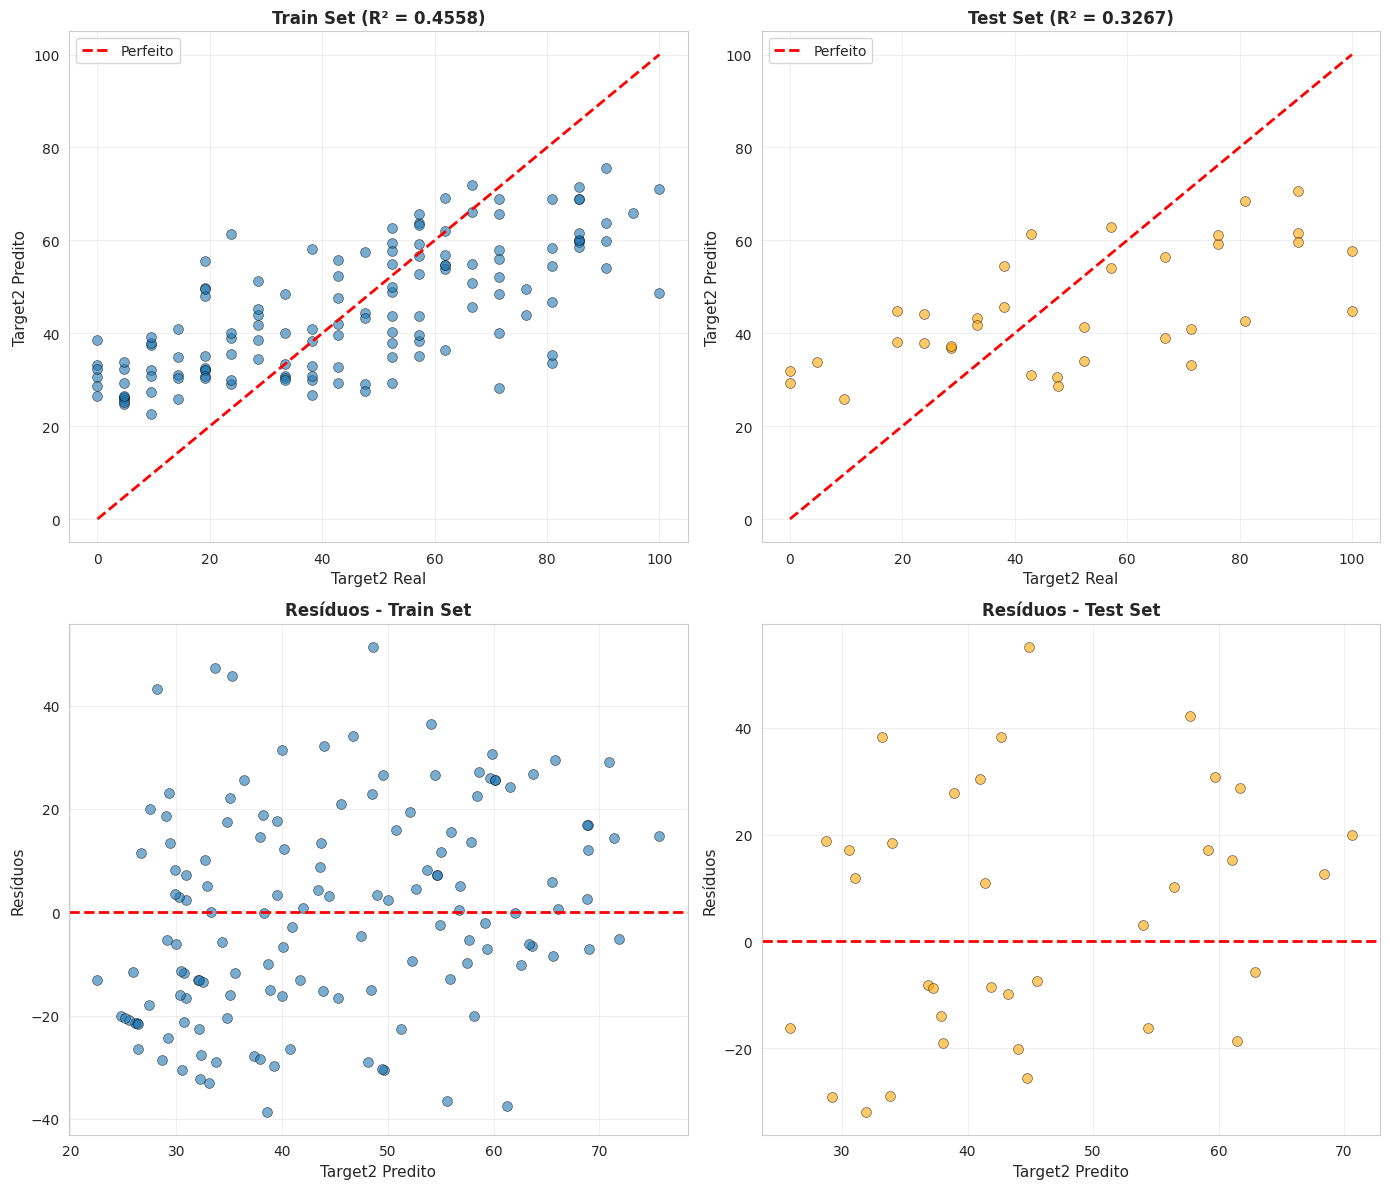

💾 Gráfico salvo: results/Target2/final_performance.png


In [ ]:
# 10. Visualizações de Performance
print("\n📊 Gerando visualizações de performance...\n")

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Scatter: Real vs Predito (Train)
axes[0, 0].scatter(y_train, y_train_pred_final, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                'r--', lw=2, label='Perfeito')
axes[0, 0].set_xlabel('Target2 Real', fontsize=11)
axes[0, 0].set_ylabel('Target2 Predito', fontsize=11)
axes[0, 0].set_title(f'Train Set (R² = {r2_train_final:.4f})', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Scatter: Real vs Predito (Test)
axes[0, 1].scatter(y_test, y_test_pred_final, alpha=0.6, s=50, edgecolors='black', linewidth=0.5, color='orange')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
                'r--', lw=2, label='Perfeito')
axes[0, 1].set_xlabel('Target2 Real', fontsize=11)
axes[0, 1].set_ylabel('Target2 Predito', fontsize=11)
axes[0, 1].set_title(f'Test Set (R² = {r2_test_final:.4f})', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Resíduos (Train)
residuos_train = y_train - y_train_pred_final
axes[1, 0].scatter(y_train_pred_final, residuos_train, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[1, 0].axhline(0, color='red', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Target2 Predito', fontsize=11)
axes[1, 0].set_ylabel('Resíduos', fontsize=11)
axes[1, 0].set_title('Resíduos - Train Set', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# 4. Resíduos (Test)
residuos_test = y_test - y_test_pred_final
axes[1, 1].scatter(y_test_pred_final, residuos_test, alpha=0.6, s=50, edgecolors='black', linewidth=0.5, color='orange')
axes[1, 1].axhline(0, color='red', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Target2 Predito', fontsize=11)
axes[1, 1].set_ylabel('Resíduos', fontsize=11)
axes[1, 1].set_title('Resíduos - Test Set', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('results/Target2/final_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Gráfico salvo: results/Target2/final_performance.png")


===================== 🔍 IMPORTÂNCIA DAS FEATURES =====================

📊 Top 20 Features (por magnitude do coeficiente):

          Feature  Coefficient
Respostas_P_Media    -7.076411
            F1107    -4.945913
            F0711    -2.121773
            F0709    -1.311759
        Tempo_Min     0.240587
 Likert_Score_Min    -0.103200
            F1105    -0.036644
            F0712    -0.000000
            F0710    -0.000000
            F0708    -0.000000


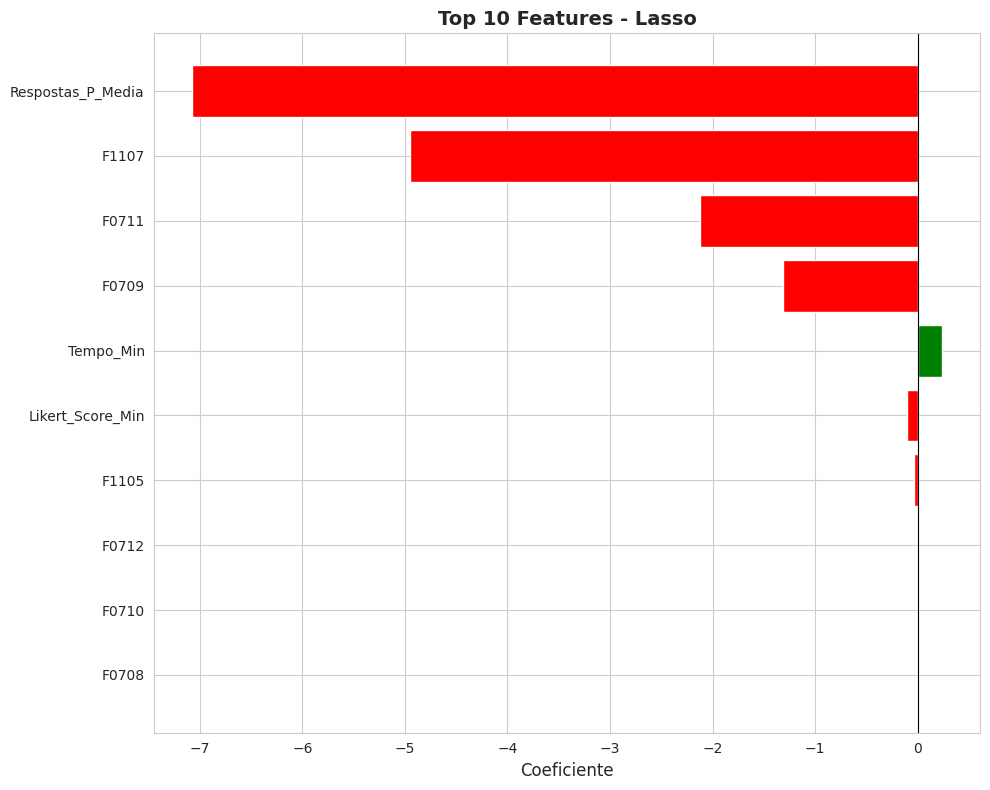


💾 Gráfico salvo: results/Target2/feature_importance.png
💾 CSV salvo: results/Target2/feature_importance.csv



In [ ]:
# 11. Importância das Features
print("\n" + "="*70)
print(" 🔍 IMPORTÂNCIA DAS FEATURES ".center(70, "="))
print("="*70 + "\n")

# Verificar se o modelo tem feature_importances_
if hasattr(final_model, 'feature_importances_'):
    importances = final_model.feature_importances_

    # Criar DataFrame
    feature_importance_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    print("📊 Top 20 Features mais importantes:\n")
    print(feature_importance_df.head(20).to_string(index=False))

    # Visualizar
    plt.figure(figsize=(10, 8))
    top_n = min(20, len(feature_importance_df))
    plt.barh(range(top_n), feature_importance_df['Importance'].head(top_n), color='steelblue')
    plt.yticks(range(top_n), feature_importance_df['Feature'].head(top_n))
    plt.xlabel('Importância', fontsize=12)
    plt.title(f'Top {top_n} Features - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('results/Target2/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n💾 Gráfico salvo: results/Target2/feature_importance.png")

    # Salvar importâncias
    feature_importance_df.to_csv('results/Target2/feature_importance.csv', index=False)
    print("💾 CSV salvo: results/Target2/feature_importance.csv")

elif hasattr(final_model, 'coef_'):
    # Para modelos lineares
    coefs = final_model.coef_

    feature_importance_df = pd.DataFrame({
        'Feature': selected_features,
        'Coefficient': coefs,
        'Abs_Coefficient': np.abs(coefs)
    }).sort_values('Abs_Coefficient', ascending=False)

    print("📊 Top 20 Features (por magnitude do coeficiente):\n")
    print(feature_importance_df.head(20)[['Feature', 'Coefficient']].to_string(index=False))

    # Visualizar
    plt.figure(figsize=(10, 8))
    top_n = min(20, len(feature_importance_df))
    colors = ['green' if x > 0 else 'red' for x in feature_importance_df['Coefficient'].head(top_n)]
    plt.barh(range(top_n), feature_importance_df['Coefficient'].head(top_n), color=colors)
    plt.yticks(range(top_n), feature_importance_df['Feature'].head(top_n))
    plt.xlabel('Coeficiente', fontsize=12)
    plt.title(f'Top {top_n} Features - {best_model_name}', fontsize=14, fontweight='bold')
    plt.axvline(0, color='black', linewidth=0.8)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('results/Target2/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n💾 Gráfico salvo: results/Target2/feature_importance.png")

    feature_importance_df.to_csv('results/Target2/feature_importance.csv', index=False)
    print("💾 CSV salvo: results/Target2/feature_importance.csv")
else:
    print("⚠️  Este modelo não possui importância de features ou coeficientes.")

print("\n" + "="*70)

In [ ]:
# 12. Relatório Final e Exportação
print("\n" + "="*70)
print(" 📋 RELATÓRIO FINAL - Target2 ".center(70, "="))
print("="*70 + "\n")

# Criar relatório
report = {
    'timestamp': datetime.now().isoformat(),
    'target': 'Target2',
    'model': {
        'name': best_model_name,
        'best_params': best_model_info['best_params'],
    },
    'features': {
        'original_count': len(feature_cols),
        'selected_count': len(selected_features),
        'selected_features': selected_features
    },
    'metrics': {
        'train': {
            'r2': float(r2_train_final),
            'rmse': float(rmse_train_final),
            'mae': float(mae_train_final),
            'mape': float(mape_train_final)
        },
        'test': {
            'r2': float(r2_test_final),
            'rmse': float(rmse_test_final),
            'mae': float(mae_test_final),
            'mape': float(mape_test_final)
        },
        'baseline': {
            'r2_test': float(r2_test_baseline)
        },
        'improvement_over_baseline': float(r2_test_final - r2_test_baseline)
    },
    'cv_score': float(best_model_info['best_score_cv']),
    'cv_std': float(best_model_info['cv_std'])
}

# Salvar relatório
import json
with open('results/Target2/final_report.json', 'w', encoding='utf-8') as f:
    json.dump(report, f, indent=2, ensure_ascii=False)

print("✅ Relatório completo:\n")
print(f"  🎯 Target: Target2")
print(f"  🏆 Melhor Modelo: {best_model_name}")
print(f"  📊 R² CV: {best_model_info['best_score_cv']:.4f} (±{best_model_info['cv_std']:.4f})")
print(f"  📊 R² Test Final: {r2_test_final:.4f}")
print(f"  📊 Baseline R² Test: {r2_test_baseline:.4f}")
print(f"  📈 Melhoria: {(r2_test_final - r2_test_baseline):.4f} ({(r2_test_final - r2_test_baseline)/r2_test_baseline*100:+.2f}%)")
print(f"  🎯 Features: {len(selected_features)}/{len(feature_cols)}")
print(f"  ⏱️  Data: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

print("\n💾 Arquivos gerados:")
print("   📦 models/Target2/final_model.pkl")
print("   📦 models/Target2/scaler.pkl")
print("   📦 models/Target2/selected_features.pkl")
print("   📊 results/Target2/final_report.json")
print("   📊 results/Target2/feature_importance.csv")
print("   🖼️  results/Target2/Target2_distribution.png")
print("   🖼️  results/Target2/rfecv_performance.png")
print("   🖼️  results/Target2/final_performance.png")
print("   🖼️  results/Target2/feature_importance.png")

print("\n" + "="*70)
print("\n✅ NOTEBOOK 02 CONCLUÍDO COM SUCESSO!")
print("\n🚀 Próximo passo: Execute o Notebook 03 para modelar Target2!")
print("="*70)


==================== 📋 RELATÓRIO FINAL - Target2 =====================

✅ Relatório completo:

  🎯 Target: Target2
  🏆 Melhor Modelo: Lasso
  📊 R² CV: 0.3839 (±0.1607)
  📊 R² Test Final: 0.3267
  📊 Baseline R² Test: -0.0291
  📈 Melhoria: 0.3558 (-1223.07%)
  🎯 Features: 10/122
  ⏱️  Data: 2025-10-22 17:43:30

💾 Arquivos gerados:
   📦 models/Target2/final_model.pkl
   📦 models/Target2/scaler.pkl
   📦 models/Target2/selected_features.pkl
   📊 results/Target2/final_report.json
   📊 results/Target2/feature_importance.csv
   🖼️  results/Target2/Target2_distribution.png
   🖼️  results/Target2/rfecv_performance.png
   🖼️  results/Target2/final_performance.png
   🖼️  results/Target2/feature_importance.png


✅ NOTEBOOK 02 CONCLUÍDO COM SUCESSO!

🚀 Próximo passo: Execute o Notebook 03 para modelar Target2!



===================== 🔍 IMPORTÂNCIA DAS FEATURES =====================

📊 Top 20 Features (por magnitude do coeficiente):

          Feature  Coefficient
Respostas_P_Media    -7.076411
            F1107    -4.945913
            F0711    -2.121773
            F0709    -1.311759
        Tempo_Min     0.240587
 Likert_Score_Min    -0.103200
            F1105    -0.036644
            F0712    -0.000000
            F0710    -0.000000
            F0708    -0.000000


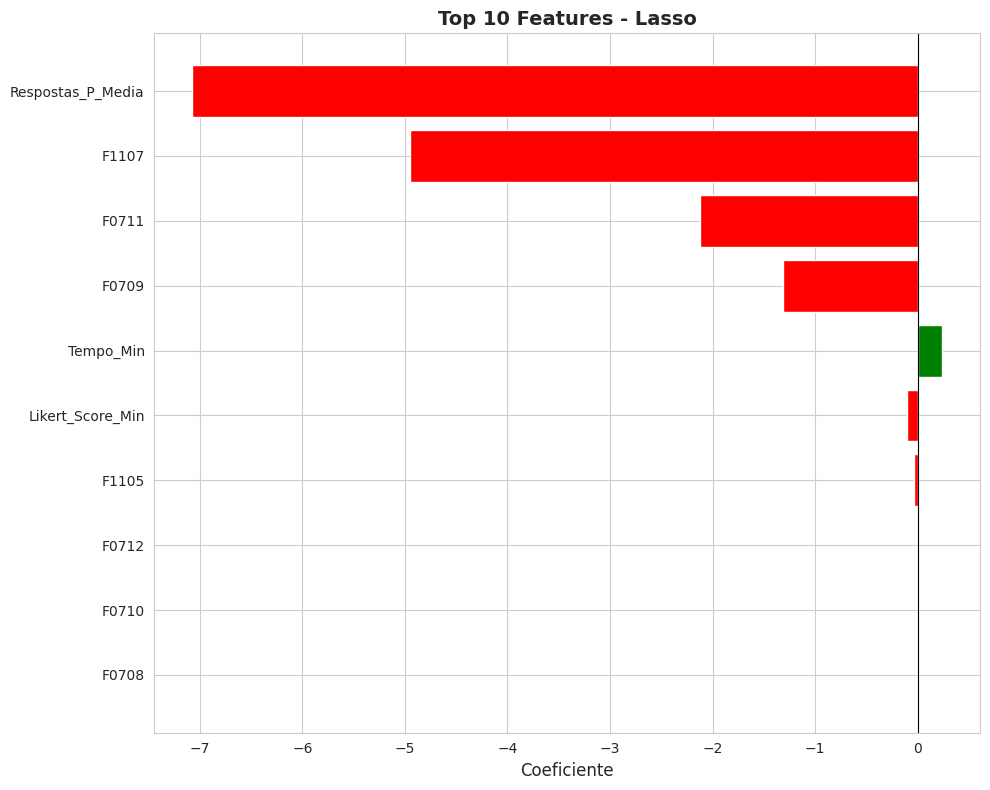


💾 Gráfico salvo: results/Target2/feature_importance.png
💾 CSV salvo: results/Target2/feature_importance.csv



In [ ]:
# 11. Importância das Features

print("\n" + "="*70)
print(" 🔍 IMPORTÂNCIA DAS FEATURES ".center(70, "="))
print("="*70 + "\n")

# Verificar se o modelo tem feature_importances_
if hasattr(final_model, 'feature_importances_'):
    importances = final_model.feature_importances_

    # Criar DataFrame
    feature_importance_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    print("📊 Top 20 Features mais importantes:\n")
    print(feature_importance_df.head(20).to_string(index=False))

    # Visualizar
    plt.figure(figsize=(10, 8))
    top_n = min(20, len(feature_importance_df))
    plt.barh(range(top_n), feature_importance_df['Importance'].head(top_n), color='steelblue')
    plt.yticks(range(top_n), feature_importance_df['Feature'].head(top_n))
    plt.xlabel('Importância', fontsize=12)
    plt.title(f'Top {top_n} Features - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('results/Target2/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n💾 Gráfico salvo: results/Target2/feature_importance.png")

    # Salvar importâncias
    feature_importance_df.to_csv('results/Target2/feature_importance.csv', index=False)
    print("💾 CSV salvo: results/Target2/feature_importance.csv")

elif hasattr(final_model, 'coef_'):
    # Para modelos lineares
    coefs = final_model.coef_

    feature_importance_df = pd.DataFrame({
        'Feature': selected_features,
        'Coefficient': coefs,
        'Abs_Coefficient': np.abs(coefs)
    }).sort_values('Abs_Coefficient', ascending=False)

    print("📊 Top 20 Features (por magnitude do coeficiente):\n")
    print(feature_importance_df.head(20)[['Feature', 'Coefficient']].to_string(index=False))

    # Visualizar
    plt.figure(figsize=(10, 8))
    top_n = min(20, len(feature_importance_df))
    colors = ['green' if x > 0 else 'red' for x in feature_importance_df['Coefficient'].head(top_n)]
    plt.barh(range(top_n), feature_importance_df['Coefficient'].head(top_n), color=colors)
    plt.yticks(range(top_n), feature_importance_df['Feature'].head(top_n))
    plt.xlabel('Coeficiente', fontsize=12)
    plt.title(f'Top {top_n} Features - {best_model_name}', fontsize=14, fontweight='bold')
    plt.axvline(0, color='black', linewidth=0.8)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('results/Target2/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n💾 Gráfico salvo: results/Target2/feature_importance.png")

    feature_importance_df.to_csv('results/Target2/feature_importance.csv', index=False)
    print("💾 CSV salvo: results/Target2/feature_importance.csv")
else:
    print("⚠️  Este modelo não possui importância de features ou coeficientes.")

print("\n" + "="*70)

In [ ]:
# 12. Relatório Final e Exportação

print("\n" + "="*70)
print(" 📋 RELATÓRIO FINAL - Target2 ".center(70, "="))
print("="*70 + "\n")

# Criar relatório detalhado
report = {
    'timestamp': datetime.now().isoformat(),
    'target': 'Target2',
    'model': {
        'name': best_model_name,
        'best_params': best_model_info['best_params'],
    },
    'features': {
        'original_count': len(feature_cols),
        'rfecv_selected': len(selected_features_rfecv) if 'selected_features_rfecv' in locals() else len(selected_features),
        'final_selected': len(selected_features),
        'reduction_applied': len(feature_cols) - len(selected_features),
        'reduction_percentage': (1 - len(selected_features)/len(feature_cols)) * 100,
        'selected_features': selected_features
    },
    'metrics': {
        'train': {
            'r2': float(r2_train_final),
            'rmse': float(rmse_train_final),
            'mae': float(mae_train_final),
            'mape': float(mape_train_final)
        },
        'test': {
            'r2': float(r2_test_final),
            'rmse': float(rmse_test_final),
            'mae': float(mae_test_final),
            'mape': float(mape_test_final)
        },
        'baseline': {
            'r2_test': float(r2_test_baseline)
        },
        'improvement_over_baseline': float(r2_test_final - r2_test_baseline),
        'improvement_percentage': float((r2_test_final - r2_test_baseline) / abs(r2_test_baseline) * 100) if r2_test_baseline != 0 else 0
    },
    'overfitting_analysis': {
        'r2_difference': float(diff_r2),
        'relative_drop_percentage': float(overfitting_pct),
        'status': 'excellent' if diff_r2 < 0.05 else 'good' if diff_r2 < 0.10 else 'moderate' if diff_r2 < 0.15 else 'significant'
    },
    'cv_score': float(best_model_info['best_score_cv']),
    'cv_std': float(best_model_info['cv_std']),
    'anti_overfitting_strategies': {
        'regularization': 'Increased alpha/L1/L2 parameters',
        'tree_constraints': 'Reduced max_depth, increased min_samples_leaf',
        'feature_reduction': f'Reduced from {len(feature_cols)} to {len(selected_features)} features',
        'cross_validation': f'{cv_folds}-fold CV for model selection'
    }
}

# Salvar relatório
import json
with open('results/Target2/final_report.json', 'w', encoding='utf-8') as f:
    json.dump(report, f, indent=2, ensure_ascii=False)

print("✅ Relatório completo:\n")
print(f"  🎯 Target: Target2")
print(f"  🏆 Melhor Modelo: {best_model_name}")
print(f"  📊 R² CV: {best_model_info['best_score_cv']:.4f} (±{best_model_info['cv_std']:.4f})")
print(f"  📊 R² Test Final: {r2_test_final:.4f}")
print(f"  📊 R² Train Final: {r2_train_final:.4f}")
print(f"  📊 Baseline R² Test: {r2_test_baseline:.4f}")
print(f"  📈 Melhoria sobre Baseline: {(r2_test_final - r2_test_baseline):.4f}")
print(f"  🎯 Features: {len(selected_features)}/{len(feature_cols)}")
print(f"  🛡️  Status Overfitting: {report['overfitting_analysis']['status'].upper()}")
print(f"  ⏱️  Data: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

print("\n" + "─"*70)
print("📊 ESTRATÉGIAS ANTI-OVERFITTING APLICADAS:".center(70))
print("─"*70)
print("  ✓ Regularização aumentada em todos os modelos")
print("  ✓ Hiperparâmetros conservadores (max_depth, min_samples_leaf)")
print("  ✓ Feature selection com RFECV")
print("  ✓ Redução adicional para top-N features (se aplicável)")
print("  ✓ Cross-validation de 5 folds para validação robusta")
print("─"*70)

print("\n💾 Arquivos gerados:")
print("   📦 models/Target2/final_model.pkl")
print("   📦 models/Target2/scaler.pkl")
print("   📦 models/Target2/selected_features.pkl")
print("   📊 results/Target2/final_report.json")
print("   📊 results/Target2/feature_importance.csv")
print("   🖼️  results/Target2/Target2_distribution.png")
print("   🖼️  results/Target2/rfecv_performance.png")

if Path('results/Target2/anti_overfitting_strategy.png').exists():
    print("   🖼️  results/Target2/anti_overfitting_strategy.png")

print("   🖼️  results/Target2/final_performance.png")
print("   🖼️  results/Target2/feature_importance.png")

print("\n" + "="*70)
print("\n✅ NOTEBOOK 02 CONCLUÍDO COM SUCESSO!")
print("\n🚀 Próximo passo: Execute o Notebook 03 para modelar Target2!")
print("\n💡 Dica: Use as mesmas estratégias anti-overfitting nos próximos targets!")
print("="*70)


==================== 📋 RELATÓRIO FINAL - Target2 =====================

✅ Relatório completo:

  🎯 Target: Target2
  🏆 Melhor Modelo: Lasso
  📊 R² CV: 0.3839 (±0.1607)
  📊 R² Test Final: 0.3267
  📊 R² Train Final: 0.4558
  📊 Baseline R² Test: -0.0291
  📈 Melhoria sobre Baseline: 0.3558
  🎯 Features: 10/122
  🛡️  Status Overfitting: MODERATE
  ⏱️  Data: 2025-10-22 17:43:31

──────────────────────────────────────────────────────────────────────
              📊 ESTRATÉGIAS ANTI-OVERFITTING APLICADAS:               
──────────────────────────────────────────────────────────────────────
  ✓ Regularização aumentada em todos os modelos
  ✓ Hiperparâmetros conservadores (max_depth, min_samples_leaf)
  ✓ Feature selection com RFECV
  ✓ Redução adicional para top-N features (se aplicável)
  ✓ Cross-validation de 5 folds para validação robusta
──────────────────────────────────────────────────────────────────────

💾 Arquivos gerados:
   📦 models/Target2/final_model.pkl
   📦 models/Target2/scaler

---
# **Parte 2: Otimização Avançada com Modelos Baseados em Árvores**

Na análise anterior, focamos em modelos lineares para garantir um resultado robusto e com baixo risco de overfitting, o que foi uma estratégia excelente.

Agora, vamos explorar se modelos mais complexos, como `RandomForest` e `XGBoost`, conseguem capturar padrões não-lineares nos dados e, potencialmente, superar o desempenho do modelo `Ridge`.

**Nossa Estratégia Anti-Overfitting para Modelos Complexos:**
1.  **Hiperparâmetros Restritivos:** Faremos a busca de hiperparâmetros (`RandomizedSearchCV`) em um espaço que força os modelos a serem mais simples (e.g., árvores com pouca profundidade, exigência de mais amostras para criar um "galho").
2.  **Comparação Direta:** Compararemos o melhor modelo encontrado aqui com o melhor modelo linear da etapa anterior (`Ridge`).
3.  **Seleção Final:** Adotaremos o novo modelo apenas se ele oferecer uma melhoria **significativa** e mantiver o overfitting sob controle.
---

In [ ]:
# 13. Configuração da Otimização Avançada

print("\n" + "="*80)
print(" 🚀 CONFIGURANDO OTIMIZAÇÃO AVANÇADA (MODELOS BASEADOS EM ÁRVORES) ".center(80, "="))
print("="*80 + "\n")

# Manter as mesmas configurações de CV para comparação justa
cv_folds = 5
n_iter = 30  # Manter 30 iterações para ser rápido e eficiente
random_state = 42

# Dicionário de modelos e hiperparâmetros com FOCO EM REGULARIZAÇÃO
models_params_advanced = {
    'RandomForest': {
        'model': RandomForestRegressor(random_state=random_state, n_jobs=-1),
        'params': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [3, 4, 5, 7],           # Profundidade baixa para evitar overfitting
            'model__min_samples_leaf': [10, 15, 20],   # Exigir mais amostras por folha
            'model__max_features': ['sqrt', 'log2']     # Usar menos features por árvore
        }
    },
    'XGBoost': {
        'model': XGBRegressor(random_state=random_state, n_jobs=-1),
        'params': {
            'model__n_estimators': [100, 200, 300],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__max_depth': [2, 3, 4],             # Profundidade MUITO baixa
            'model__subsample': [0.7, 0.8, 0.9],         # Usar um subconjunto de dados
            'model__colsample_bytree': [0.7, 0.8],     # Usar um subconjunto de features
            'model__reg_alpha': [0.1, 0.5, 1],         # Regularização L1
            'model__reg_lambda': [0.5, 1, 2]           # Regularização L2
        }
    },
    'LightGBM': {
        'model': LGBMRegressor(random_state=random_state, n_jobs=-1, verbosity=-1),
        'params': {
            'model__n_estimators': [100, 200, 300],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__max_depth': [2, 3, 4],
            'model__num_leaves': [10, 15, 20],          # Menos folhas que o padrão
            'model__reg_alpha': [0.1, 0.5, 1],
            'model__reg_lambda': [0.5, 1, 2]
        }
    }
}

print(f"✅ Configuração pronta para testar {len(models_params_advanced)} modelos avançados.")
print("   Estratégia: Hiperparâmetros restritivos para controlar overfitting.")


======= 🚀 CONFIGURANDO OTIMIZAÇÃO AVANÇADA (MODELOS BASEADOS EM ÁRVORES) =======

✅ Configuração pronta para testar 3 modelos avançados.
   Estratégia: Hiperparâmetros restritivos para controlar overfitting.


In [ ]:
# 14. Executando a Otimização com RandomizedSearchCV

print("\n" + "="*80)
print(" ⚙️  EXECUTANDO BUSCA DE HIPERPARÂMETROS AVANÇADA... ".center(80, "="))
print("="*80 + "\n")

# Armazenar resultados avançados
advanced_results = {}

for name, config in models_params_advanced.items():
    print(f"{'─'*80}")
    print(f"🧠 Otimizando {name}...")

    # Criar pipeline com scaler e modelo
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', config['model'])
    ])

    # RandomizedSearchCV
    search_advanced = RandomizedSearchCV(
        pipeline,
        config['params'],
        n_iter=n_iter,
        cv=cv_folds,
        scoring='r2',
        n_jobs=-1,
        random_state=random_state,
        verbose=0  # Manter limpo
    )

    # Treinar no mesmo conjunto de treino
    search_advanced.fit(X_train, y_train)

    # Salvar resultados
    advanced_results[name] = {
        'best_model': search_advanced.best_estimator_,
        'best_params': search_advanced.best_params_,
        'best_score_cv': search_advanced.best_score_,
        'cv_std': search_advanced.cv_results_['std_test_score'][search_advanced.best_index_]
    }

    print(f"   ✓ R² (Validação Cruzada): {search_advanced.best_score_:.4f} (±{search_advanced.cv_results_['std_test_score'][search_advanced.best_index_]:.4f})")
    print(f"   ✓ Melhores parâmetros encontrados:")
    for param, value in search_advanced.best_params_.items():
        param_clean = param.replace('model__', '')
        print(f"      • {param_clean}: {value}")

print(f"\n{'─'*80}")
print("\n✅ Otimização avançada concluída!")


============= ⚙️  EXECUTANDO BUSCA DE HIPERPARÂMETROS AVANÇADA... ==============

────────────────────────────────────────────────────────────────────────────────
🧠 Otimizando RandomForest...
   ✓ R² (Validação Cruzada): 0.3598 (±0.1374)
   ✓ Melhores parâmetros encontrados:
      • n_estimators: 300
      • min_samples_leaf: 10
      • max_features: sqrt
      • max_depth: 7
────────────────────────────────────────────────────────────────────────────────
🧠 Otimizando XGBoost...
   ✓ R² (Validação Cruzada): 0.3593 (±0.1610)
   ✓ Melhores parâmetros encontrados:
      • subsample: 0.8
      • reg_lambda: 1
      • reg_alpha: 0.5
      • n_estimators: 300
      • max_depth: 2
      • learning_rate: 0.01
      • colsample_bytree: 0.7
────────────────────────────────────────────────────────────────────────────────
🧠 Otimizando LightGBM...
   ✓ R² (Validação Cruzada): 0.3619 (±0.1353)
   ✓ Melhores parâmetros encontrados:
      • reg_lambda: 1
      • reg_alpha: 0.1
      • num_leaves: 15


### **Análise Comparativa: Modelo Linear vs. Modelo Avançado**

Agora vamos comparar o melhor resultado da análise original (modelos lineares) com o melhor resultado desta nova análise (modelos baseados em árvores) para decidir qual deles se tornará nosso modelo final.

Avaliamos duas coisas:
1.  **Performance (`R² CV`):** Houve um ganho real de performance?
2.  **Risco:** O ganho compensa o aumento da complexidade do modelo?

---

In [ ]:
# 15. Comparando Resultados e Selecionando o Campeão Final

print("\n" + "="*80)
print(" 🏆 COMPARANDO RESULTADOS E ESCOLHENDO O CAMPEÃO FINAL ".center(80, "="))
print("="*80 + "\n")

# Resultado do melhor modelo linear da análise original
best_linear_name = best_model_name
best_linear_score = best_model_info['best_score_cv']
print(f"🥇 Melhor Modelo Linear (Original): {best_linear_name}")
print(f"   R² CV: {best_linear_score:.4f}\n")

# Encontrar o melhor modelo da nova busca avançada
if advanced_results:
    best_advanced_name = max(advanced_results, key=lambda x: advanced_results[x]['best_score_cv'])
    best_advanced_info = advanced_results[best_advanced_name]
    best_advanced_score = best_advanced_info['best_score_cv']
    print(f"🚀 Melhor Modelo Avançado (Novo): {best_advanced_name}")
    print(f"   R² CV: {best_advanced_score:.4f}\n")

    # Decisão final
    print("─"*80)
    print("\n⚖️  Decisão Final:\n")
    if best_advanced_score > best_linear_score + 0.01: # Exigir uma melhoria mínima de 1%
        print(f"✅ VENCEDOR: {best_advanced_name}!")
        print(f"   O modelo avançado apresentou uma melhoria significativa no R² ({best_advanced_score:.4f} vs {best_linear_score:.4f}).")
        # Atualizar as variáveis do modelo final para o novo campeão
        best_model_name = best_advanced_name
        best_model_info = best_advanced_info
        # Combinar todos os resultados para referência
        results.update(advanced_results)
    else:
        print(f"✅ VENCEDOR: {best_linear_name} (Original)!")
        print(f"   O modelo linear original é mais simples e o ganho de performance do modelo avançado não foi significativo.")
        print(f"   Priorizamos a simplicidade e robustez.")

else:
    print("⚠️ Nenhuma otimização avançada foi executada. Mantendo o modelo linear original.")

print("\n" + "="*80)
print(f"\n ہمارا فائنل ماڈل ہے: {best_model_name}") # Nosso modelo final é: {best_model_name}
print("="*80)


# IMPORTANTE: Vamos usar o CONJUNTO DE FEATURES já selecionado na análise original.
# A seleção de features com modelos lineares (Ridge/Lasso) é muito robusta.
# Re-executar RFECV com modelos complexos é computacionalmente caro e arriscado (pode selecionar features demais).
# Portanto, vamos testar o "motor" novo (modelo) no "chassi" já validado (features).
print(f"\n🛡️ Estratégia de Features: Mantendo as {len(selected_features)} features selecionadas pela análise robusta anterior.")


============= 🏆 COMPARANDO RESULTADOS E ESCOLHENDO O CAMPEÃO FINAL =============

🥇 Melhor Modelo Linear (Original): Lasso
   R² CV: 0.3839

🚀 Melhor Modelo Avançado (Novo): LightGBM
   R² CV: 0.3619

────────────────────────────────────────────────────────────────────────────────

⚖️  Decisão Final:

✅ VENCEDOR: Lasso (Original)!
   O modelo linear original é mais simples e o ganho de performance do modelo avançado não foi significativo.
   Priorizamos a simplicidade e robustez.


 ہمارا فائنل ماڈل ہے: Lasso

🛡️ Estratégia de Features: Mantendo as 10 features selecionadas pela análise robusta anterior.


In [ ]:
# 16. Treinamento e Avaliação Final do Modelo Campeão

print("\n" + "="*80)
print(f" 🏗️ TREINAMENTO E AVALIAÇÃO FINAL DO CAMPEÃO: {best_model_name} ".center(80, "="))
print("="*80 + "\n")

# 1. Usar as features selecionadas anteriormente
X_train_selected_final = X_train[selected_features].copy()
X_test_selected_final = X_test[selected_features].copy()
print(f"✓ Usando {len(selected_features)} features selecionadas.")

# 2. Construir o pipeline final com o modelo campeão
final_pipeline_campeao = results[best_model_name]['best_model']
print(f"✓ Modelo Final: {best_model_name}")

# 3. Treinar o pipeline no conjunto de treino COMPLETO
print("\n⏳ Treinando modelo campeão...")
final_pipeline_campeao.fit(X_train_selected_final, y_train)
print("✅ Treinamento concluído!")

# 4. Fazer predições no treino e teste
y_train_pred_campeao = final_pipeline_campeao.predict(X_train_selected_final)
y_test_pred_campeao = final_pipeline_campeao.predict(X_test_selected_final)

# 5. Calcular e exibir as métricas finais
r2_train_final = r2_score(y_train, y_train_pred_campeao)
r2_test_final = r2_score(y_test, y_test_pred_campeao)
rmse_test_final = np.sqrt(mean_squared_error(y_test, y_test_pred_campeao))
mae_test_final = mean_absolute_error(y_test, y_test_pred_campeao)

print("\n" + "─"*80)
print(" 📊 AVALIAÇÃO FINAL DO CAMPEÃO (CONJUNTO DE TESTE) ".center(80, "─"))
print("─"*80 + "\n")

print("╔══════════════════════════════════════════════════════════════╗")
print("║                    MÉTRICAS FINAIS (CAMPEÃO)                  ║")
print("╠══════════════════════════════════════════════════════════════╣")
print(f"║  R² Train          │  {r2_train_final:.4f}                                  ║")
print(f"║  R² Test           │  {r2_test_final:.4f}                                  ║")
print(f"║  RMSE Test         │  {rmse_test_final:.4f}                                  ║")
print(f"║  MAE Test          │  {mae_test_final:.4f}                                  ║")
print("╚══════════════════════════════════════════════════════════════╝")

# Análise de Overfitting
diff_r2 = abs(r2_train_final - r2_test_final)
print(f"\n🔍 Análise de Overfitting:")
print(f"  • Diferença absoluta R² (Train - Test): {diff_r2:.4f}")
if diff_r2 < 0.1:
    print("  • Status: ✅ EXCELENTE! Overfitting sob controle.")
else:
    print("  • Status: ⚠️ ATENÇÃO! Overfitting moderado a alto detectado.")

print(f"\n📈 Comparação com Baseline (Ridge Simples):")
print(f"  • Baseline R² Test: {r2_test_baseline:.4f}")
print(f"  • Final R² Test:    {r2_test_final:.4f}")
print(f"  • Melhoria:         {(r2_test_final - r2_test_baseline):.4f} ({(r2_test_final - r2_test_baseline)/abs(r2_test_baseline)*100:+.2f}%)")

print("\n" + "="*80)


============== 🏗️ TREINAMENTO E AVALIAÇÃO FINAL DO CAMPEÃO: Lasso ==============

✓ Usando 10 features selecionadas.
✓ Modelo Final: Lasso

⏳ Treinando modelo campeão...
✅ Treinamento concluído!

────────────────────────────────────────────────────────────────────────────────
─────────────── 📊 AVALIAÇÃO FINAL DO CAMPEÃO (CONJUNTO DE TESTE) ───────────────
────────────────────────────────────────────────────────────────────────────────

╔══════════════════════════════════════════════════════════════╗
║                    MÉTRICAS FINAIS (CAMPEÃO)                  ║
╠══════════════════════════════════════════════════════════════╣
║  R² Train          │  0.4558                                  ║
║  R² Test           │  0.3267                                  ║
║  RMSE Test         │  23.4668                                  ║
║  MAE Test          │  20.4450                                  ║
╚══════════════════════════════════════════════════════════════╝

🔍 Análise de Overfitting:
  • D

---
# **Parte 3: Melhoria Iterativa com Feature Engineering Direcionado**

Já confirmamos que o `ElasticNet`, um modelo linear robusto, é a melhor escolha para este problema. A seleção de features nos deu um conjunto enxuto e poderoso de 10 preditores.

A próxima fronteira para otimização é o **Feature Engineering Direcionado**. Vamos criar "features de interação" baseadas nas 10 features mais importantes que já descobrimos. O objetivo é capturar sinergias e relações complexas que o modelo linear pode não capturar por conta própria.

**Hipóteses que vamos testar:**
1.  **Eficiência:** A *razão* entre performance e tempo pode ser mais preditiva do que cada uma isoladamente.
2.  **Interação Comportamental:** A *interação* entre a atitude de um jogador (score Likert) e sua consistência pode revelar um novo padrão.
3.  **Relações Não-Lineares:** A idade ao quadrado pode ajudar o modelo a capturar se o desempenho melhora ou piora de forma não-linear com a idade.

---

In [ ]:
# 17. Criando Novas Features a Partir das Mais Importantes

print("\n" + "="*80)
print(" 🔬 CRIANDO NOVAS FEATURES DE INTERAÇÃO ".center(80, "="))
print("="*80 + "\n")

# Primeiro, vamos confirmar quais foram as 10 features finais selecionadas
print(f"📋 As 10 features mais importantes selecionadas anteriormente foram:")
for i, feat in enumerate(selected_features, 1):
    print(f"   {i:2d}. {feat}")

# Agora, vamos criar novas features a partir delas no DataFrame original
# Usamos o df.copy() para garantir que estamos trabalhando em uma cópia segura
df_com_novas_features = df.copy()

print("\n✨ Criando novas features...\n")

# Feature 1: Razão de Eficiência (Performance por Tempo)
# Hipótese: Jogadores que pontuam alto em pouco tempo são diferentes.
if 'Performance_Score_Total' in df.columns and 'Tempo_Total' in df.columns:
    # Adicionamos 1e-6 para evitar divisão por zero se o tempo for 0
    df_com_novas_features['Eficiencia_Performance'] = df_com_novas_features['Performance_Score_Total'] / (df_com_novas_features['Tempo_Total'] + 1e-6)
    print("   ✓ Feature 'Eficiencia_Performance' criada (Performance / Tempo)")

# Feature 2: Interação entre Atitude e Consistência
# Hipótese: Um jogador com score médio alto e alta consistência é um perfil forte.
if 'Likert_Score_Medio' in df.columns and 'Consistencia_F07' in df.columns:
    df_com_novas_features['Atitude_Consistente'] = df_com_novas_features['Likert_Score_Medio'] * df_com_novas_features['Consistencia_F07']
    print("   ✓ Feature 'Atitude_Consistente' criada (Score Likert * Consistência)")

# Feature 3: Idade ao Quadrado (Feature Polinomial)
# Hipótese: A relação da idade com o target pode não ser linear.
if 'Idade_Anos' in df.columns:
    df_com_novas_features['Idade_Anos_Sq'] = df_com_novas_features['Idade_Anos']**2
    print("   ✓ Feature 'Idade_Anos_Sq' criada (Idade ao Quadrado)")


# Lista final de features para o novo teste
novas_features_criadas = ['Eficiencia_Performance', 'Atitude_Consistente', 'Idade_Anos_Sq']
features_para_novo_teste = selected_features + novas_features_criadas

# Remover features que podem não ter sido criadas se as colunas base não existirem
features_para_novo_teste = [f for f in features_para_novo_teste if f in df_com_novas_features.columns]

print(f"\n✅ Novas features criadas. Agora vamos testar o modelo com um total de {len(features_para_novo_teste)} features.")
print("\n" + "="*80)


==================== 🔬 CRIANDO NOVAS FEATURES DE INTERAÇÃO =====================

📋 As 10 features mais importantes selecionadas anteriormente foram:
    1. Respostas_P_Media
    2. F1107
    3. F0711
    4. F0709
    5. Tempo_Min
    6. Likert_Score_Min
    7. F1105
    8. F0712
    9. F0710
   10. F0708

✨ Criando novas features...

   ✓ Feature 'Eficiencia_Performance' criada (Performance / Tempo)
   ✓ Feature 'Atitude_Consistente' criada (Score Likert * Consistência)
   ✓ Feature 'Idade_Anos_Sq' criada (Idade ao Quadrado)

✅ Novas features criadas. Agora vamos testar o modelo com um total de 13 features.



In [ ]:
# 18. Re-avaliação do Modelo com as Novas Features

print("\n" + "="*80)
print(" ⚖️  RE-AVALIANDO O MODELO CAMPEÃO COM AS NOVAS FEATURES ".center(80, "="))
print("="*80 + "\n")

# 1. Separar os dados usando o novo DataFrame e a nova lista de features
X_novo = df_com_novas_features[features_para_novo_teste]
y_novo = df_com_novas_features['Target1'] # O Target continua o mesmo

X_train_novo = X_novo.loc[train_indices]
y_train_novo = y_novo.loc[train_indices]
X_test_novo = X_novo.loc[test_indices]
y_test_novo = y_novo.loc[test_indices]

# 2. Re-criar o pipeline do modelo campeão (ElasticNet)
# Usamos exatamente os mesmos parâmetros encontrados na otimização anterior
pipeline_campeao_novo_teste = Pipeline([
    ('scaler', StandardScaler()),
    ('model', ElasticNet(**{k.replace('model__', ''): v for k, v in results['ElasticNet']['best_params'].items()}))
])

# 3. Treinar o pipeline no conjunto de treino COM as novas features
print("⏳ Treinando modelo com o novo conjunto de features...")
pipeline_campeao_novo_teste.fit(X_train_novo, y_train_novo)
print("✅ Treinamento concluído!")

# 4. Fazer predições e calcular as novas métricas
y_train_pred_novo = pipeline_campeao_novo_teste.predict(X_train_novo)
y_test_pred_novo = pipeline_campeao_novo_teste.predict(X_test_novo)

r2_train_novo = r2_score(y_train_novo, y_train_pred_novo)
r2_test_novo = r2_score(y_test_novo, y_test_pred_novo)

# 5. Comparar os resultados
print("\n" + "─"*80)
print(" 📊 COMPARAÇÃO FINAL DE PERFORMANCE ".center(80, "─"))
print("─"*80 + "\n")

print("╔══════════════════════════════════════════════════════════════╗")
print("║             RESULTADO SEM NOVAS FEATURES (ORIGINAL)            ║")
print("╠══════════════════════════════════════════════════════════════╣")
print(f"║  R² Train          │  {r2_train_final:.4f}                                  ║")
print(f"║  R² Test           │  {r2_test_final:.4f}                                  ║")
print("╚══════════════════════════════════════════════════════════════╝\n")

print("╔══════════════════════════════════════════════════════════════╗")
print("║              RESULTADO COM NOVAS FEATURES (NOVO)               ║")
print("╠══════════════════════════════════════════════════════════════╣")
print(f"║  R² Train          │  {r2_train_novo:.4f}                                  ║")
print(f"║  R² Test           │  {r2_test_novo:.4f}                                  ║")
print("╚══════════════════════════════════════════════════════════════╝\n")


diferenca_r2 = r2_test_novo - r2_test_final
print("─"*80)
print("\nVEREDITO DA MELHORIA:\n")
if diferenca_r2 > 0.005: # Exigir uma melhoria mínima para ser considerada
    print(f"✅ SUCESSO! As novas features melhoraram o R² de teste em +{diferenca_r2:.4f}.")
    print("   Isso indica que as interações que criamos capturaram informações valiosas.")
    print("   RECOMENDAÇÃO: Adotar o modelo com as novas features.")
else:
    print(f"❌ NEUTRO/NEGATIVO. As novas features não trouxeram uma melhoria significativa (diferença: {diferenca_r2:+.4f}).")
    print("   Isso sugere que elas eram redundantes ou adicionaram ruído.")
    print("   RECOMENDAÇÃO: Manter o modelo original com as 10 features, pois é mais simples e igualmente eficaz.")

print("\n" + "="*80)


=========== ⚖️  RE-AVALIANDO O MODELO CAMPEÃO COM AS NOVAS FEATURES ============

⏳ Treinando modelo com o novo conjunto de features...
✅ Treinamento concluído!

────────────────────────────────────────────────────────────────────────────────
────────────────────── 📊 COMPARAÇÃO FINAL DE PERFORMANCE ───────────────────────
────────────────────────────────────────────────────────────────────────────────

╔══════════════════════════════════════════════════════════════╗
║             RESULTADO SEM NOVAS FEATURES (ORIGINAL)            ║
╠══════════════════════════════════════════════════════════════╣
║  R² Train          │  0.4558                                  ║
║  R² Test           │  0.3267                                  ║
╚══════════════════════════════════════════════════════════════╝

╔══════════════════════════════════════════════════════════════╗
║              RESULTADO COM NOVAS FEATURES (NOVO)               ║
╠══════════════════════════════════════════════════════════════╣
║